In [1]:
from utils import *

In [2]:
def get_clip_duration(fname):
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    return duration

    y, sr = librosa.load(fname, sr=None, offset=0., duration=MIN_CLIP_DURATION)
    return librosa.core.get_duration(y, sr=sr)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_user_ids = os.listdir(get_rel_path(TRAIN_PATH))

In [5]:
def get_user_clips(clips_per_user=CLIPS_PER_USER):
    ### all_user_clips is list of clips representing user and their list of clips
    all_user_clips = []
    
    with open(get_rel_path('clips_list.txt'), 'r') as f:
        for line in tqdm(f):
            paths = line.split()
            paths = [get_rel_path("/".join(p.split("/")[2:])) 
                     for p in paths]
            paths = [p for p in paths if get_clip_duration(p) > MIN_CLIP_DURATION]
            if len(paths) < CLIPS_PER_USER:
                continue
                
            assert len(paths) > CLIPS_PER_USER 
            all_user_clips.extend(paths[: clips_per_user])
        
#     assert len(Counter(all_user_clips)) > 1
    return all_user_clips

In [6]:
all_user_clips = get_user_clips()
print(len(all_user_clips), "clips")

100it [00:00, 158.29it/s]

1000 clips


In [7]:
all_durations = np.array([get_clip_duration(p) for p in all_user_clips])
assert all_durations.min() > MIN_CLIP_DURATION

In [8]:
def get_waveform(clip_list, offset=0., duration=MIN_CLIP_DURATION):
    all_x = []
    all_sr = []
    for path in tqdm(clip_list):
        x, sr = librosa.load(path, sr=None, offset=offset, 
                             duration=duration)
        all_x.append(x)
        all_sr.append(sr)
        
    assert len(np.unique(np.array(all_sr))) == 1
    return all_x, all_sr

In [9]:
all_x, all_sr = get_waveform(all_user_clips)

100%|██████████| 1000/1000 [00:01<00:00, 585.74it/s]


In [10]:
assert len(np.unique(np.array([x.shape[0] for x in all_x]))) == 1, str(len(np.unique(np.array([x.shape[0] for x in all_x]))))

In [11]:
def get_stft(all_x, nperseg=400, noverlap=239, nfft=1023):
    all_stft = []
    for x in tqdm(all_x):
        _, _, Z = scipy.signal.stft(x, window="hamming", 
                                       nperseg=nperseg,
                                       noverlap=noverlap,
                                       nfft=nfft)
        Z = sklearn.preprocessing.normalize(np.abs(Z), axis=1)        
        assert Z.shape[0] == 512
        all_stft.append(Z)
    
    return np.array(all_stft)

In [12]:
all_stft = get_stft(all_x)
print(all_stft[0].shape)

100%|██████████| 1000/1000 [00:10<00:00, 94.64it/s]


(512, 498)


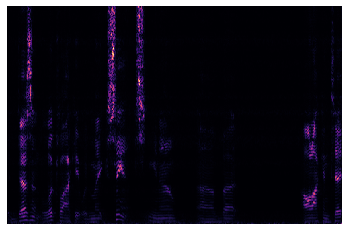

In [13]:
librosa.display.specshow(all_stft[0], sr=all_sr[0])
plt.show()

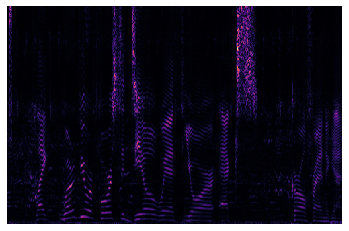

In [14]:
librosa.display.specshow(all_stft[-2], sr=all_sr[0])
plt.show()

In [15]:
def save_stft(all_stft, all_user_clips):
    all_stft_paths = []
    for i, user_path in tqdm(enumerate(all_user_clips)):
        user_stft = all_stft[i]
        stft_fname = '_'.join(user_path.split('/')[-3:])[:-4] + '.npy'
        stft_path = get_rel_path(os.path.join(STFT_FOLDER, stft_fname))
        np.save(stft_path, user_stft)
        all_stft_paths.append(stft_path)
    return all_stft_paths

In [16]:
stft_paths = save_stft(all_stft, all_user_clips)

1000it [00:09, 101.11it/s]


In [17]:
stft_paths[0]

'stft5/id10095_YOjB3bkUrUA_00002.npy'

In [18]:
data = list(itertools.product(stft_paths, stft_paths))
df = pd.DataFrame(data, columns=["path1", "path2"])
df = df[~(df.path1 == df.path2)]  # to drop samples when path1 and path2 are same

In [19]:
df['user1'] = df['path1'].apply(lambda x: x[x.find('/')+1: x.find('_')])
df['user2'] = df['path2'].apply(lambda x: x[x.find('/')+1: x.find('_')])
df['label'] = (df.user1 == df.user2).astype('int')
df['label'] = np.abs(df.label - 1)
print("Total unique users", df.user1.nunique()) 
assert df.user1.nunique() == TOTAL_USERS
assert df.user2.nunique() == TOTAL_USERS
print("len", len(df))
df.sample(5)

Total unique users 100
len 999000


,path1,path2,user1,user2,label
508620,stft5/id10050__xeGTvcvg-s_00004.npy,stft5/id10037_xWYJB2Ua7DA_00002.npy,id10050,id10037,1
534406,stft5/id10045_FdYLFLTY-5Q_00012.npy,stft5/id10058_ewwS4FafxYM_00002.npy,id10045,id10058,1
182637,stft5/id10085_2Cv7-z2QZPI_00009.npy,stft5/id10033_QUZSHTlha6A_00002.npy,id10085,id10033,1
658455,stft5/id10039_e93OOf47Qak_00015.npy,stft5/id10052_fi3V4OzrkaA_00003.npy,id10039,id10052,1
613431,stft5/id10038_LM31XDZNX6M_00006.npy,stft5/id10056_5tgoikTak5A_00011.npy,id10038,id10056,1


In [20]:
df.label.value_counts()

1    990000
0      9000
Name: label, dtype: int64

In [21]:
# pairs_df = []
# for user in df.user1.unique():
#     user_df = df[df.user1 == user]
#     similar = user_df[user_df['label'] == 0].sample(n=SIMILAR_PAIRS)
#     dissimilar = user_df[user_df['label'] == 1].sample(n=DISSIMILAR_PAIRS)
#     pairs_df.append(pd.concat([similar, dissimilar]))

# pairs_df = pd.concat(pairs_df)
# assert len(pairs_df) == (SIMILAR_PAIRS + DISSIMILAR_PAIRS) * TOTAL_USERS

In [22]:
# print(len(pairs_df))
# pairs_df.head()

In [23]:
pairs_df = df

In [24]:
pairs_df.to_csv(PAIRS_FILE, index=False)